In [107]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

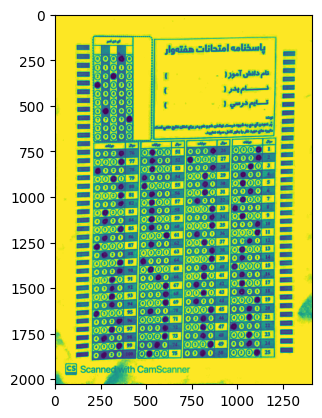

In [108]:
image  = cv2.imread('image.JPG')
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray = clahe.apply(gray)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

plt.imshow(blurred)

## Apply Thresholding: Convert the grayscale image to binary (black and white).

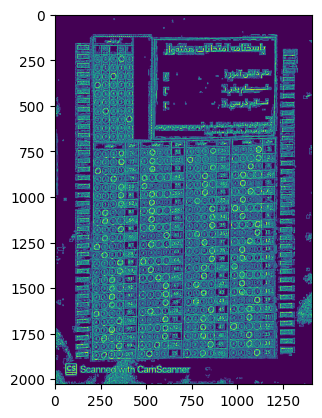

In [109]:
binary = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

plt.imshow(binary)

## Detect Circles

In [110]:
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    if perimeter > 0:
        circularity = 4 * 3.1415 * (area / (perimeter * perimeter))
        if 0.7 < circularity <= 1.2:  # Threshold for circularity
            cv2.drawContours(image, [cnt], -1, (0, 255, 0), 2)


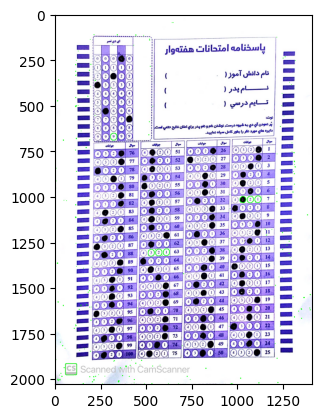

In [111]:
plt.imshow(image)